# Spam SMS Detection

Sutirtha Mukherjee \
18-11-2023

## Contents
- [Project Overview](#project-overview)
- [Importing Libraries](#importing-libraries)
- [Load Data](#load-data)
- [Data Cleaning](#data-cleaning)
- [Data Partitioning](#data-partitioning)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Data Preprocessing for Modelling](#data-preprocessing-for-modelling)
- [Machine Learning Models](#machine-learning-models)
- [Conclusions](#conclusions)

## Project Overview <a id="project-overview"></a>


In this machine learning (ML) project, our main goal is to develop ML models capable of classifying SMS messages as either SPAM or legitimate based on their textual information. We will use natural language processing techniques and classification algorithms to achieve this goal.

Specifically we are going to:
1. Use text processing techniques such as TF-IDF to transform textual data into numerical vectors suitable for machine learning.   

2. Apply various classification algorithms, including Naive Bayes, Logistic Regression, Support Vector Machines, Random Forest, and XGBoost to determine the most effective model for our objective.

3. Maximize the model's performance through exploratory data analysis, feature engineering and fine-tuning hyperparameters.



### About the Dataset
The dataset was sourced from Kaggle at the following link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset. It consists of SMS messages tagged as either ham (legitimate) or spam, collected from various sources including the Grumbletext website, NUS SMS Corpus and Caroline Tagg's PhD Thesis. The dataset contains a total of 5572 SMS messages in English.

## Importing Libraries <a id="importing-libraries"></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate,StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,roc_curve,make_scorer

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

## Load data <a id="load-data"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CodSoftInternship/SpamSMSPrediction/spam.csv',encoding='latin1')
data = data[["v1","v2"]]
data.columns = ['type','text']
data.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Cleaning <a id="data-cleaning"></a>

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


- Checking duplicated rows :

In [ ]:
data.duplicated().sum()

403

In [ ]:
data.drop_duplicates(keep="first",inplace=True)

In [ ]:
data.duplicated().sum()

0

- Checking null values :

In [ ]:
data.isnull().sum()

type    0
text    0
dtype: int64

There is no missing value in the datasets.

- Mapping ham and spam to 0 and 1 respectively :

In [ ]:
data.type = data.type.map({"ham":0,"spam":1})

## Data Partitioning <a id="data-partitioning"></a>

- Separating input features and target labels :

In [ ]:
X = data["text"]
y = data["type"]

In [ ]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: type, Length: 5169, dtype: int64

- Train-Test split :

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [ ]:
y_train.value_counts()

0    3613
1     522
Name: type, dtype: int64

In [ ]:
y_test.value_counts()

0    903
1    131
Name: type, dtype: int64

In [ ]:
train_data = pd.concat([X_train,y_train],axis=1)
test_data = pd.concat([X_test,y_test],axis=1)

In [ ]:
test_data.type.value_counts()

0    903
1    131
Name: type, dtype: int64

## Exploratory Data Analysis <a id="exploratory-data-analysis"></a>

### The Target Imbalance

In [ ]:
train_data[train_data.type==1].head()

,text,type
1049,18 days to Euro2004 kickoff! U will be kept in...,1
4014,You will be receiving this week's Triple Echo ...,1
1136,Dont forget you can place as many FREE Request...,1
2877,Hey Boys. Want hot XXX pics sent direct 2 ur p...,1
2668,Wanna get laid 2nite? Want real Dogging locati...,1


In [ ]:
train_data.type.unique()

array([0, 1])

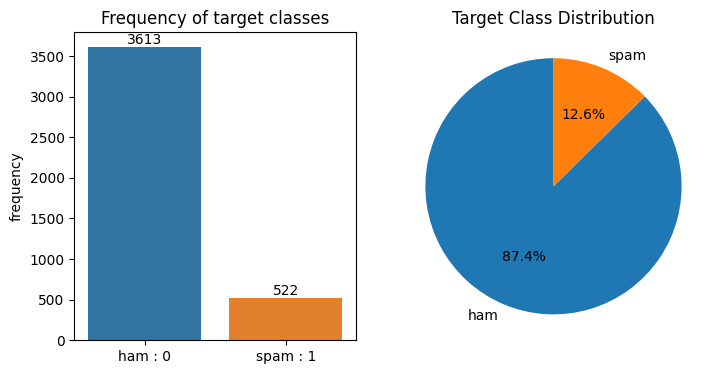

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.barplot(x=['ham : 0','spam : 1'],y=train_data["type"].value_counts())

for i, count in enumerate(train_data["type"].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.title("Frequency of target classes")
plt.ylabel("frequency")

plt.subplot(1,2,2)
plt.pie(train_data["type"].value_counts(), labels=['ham','spam'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Target Class Distribution')
plt.show()

The dataset exhibits class imbalance, with the minority target class possessing only 12.6% of the data.

### Wordclouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
ham_text = " ".join([x.lower() for x in train_data[train_data["type"]==0]["text"]])
stopwords = set(STOPWORDS)
stopwords.update(["u"])
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(ham_text)

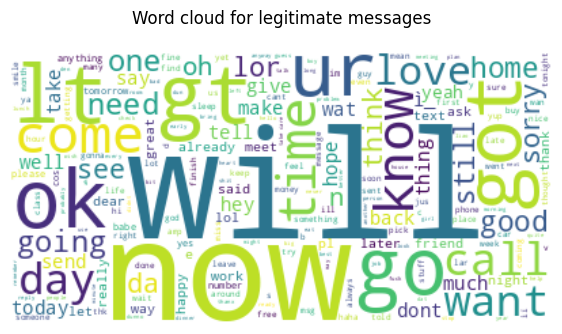

In [ ]:
plt.figure(figsize=(7,4))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for legitimate messages\n")
plt.show()

In [ ]:
spam_text = " ".join([x.lower() for x in train_data[train_data["type"]==1]["text"]])
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(spam_text)

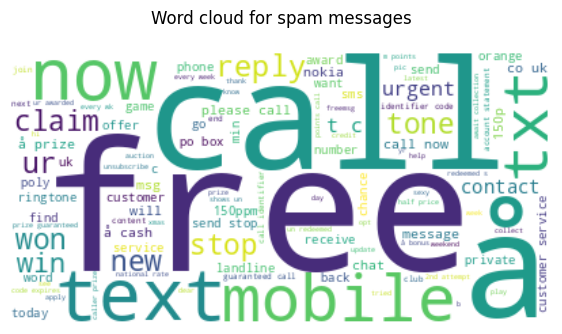

In [ ]:
plt.figure(figsize=(7,4))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for spam messages\n")
plt.show()

## Data Preprocessing for Modelling <a id="data-preprocessing-for-modelling"></a>

In [ ]:
X_train

336     Cool. So how come you havent been wined and di...
390                             Huh so late... Fr dinner?
583     my ex-wife was not able to have kids. Do you w...
1387    Hope ur head doesn't hurt 2 much ! Am ploughin...
1095                              Ryder unsold.now gibbs.
                              ...                        
606     XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIAL...
105     Thanks a lot for your wishes on my birthday. T...
3789    I love you !!! You know? Can you feel it? Does...
1911    Lol grr my mom is taking forever with my presc...
3742    Nah, Wednesday. When should I bring the mini c...
Name: text, Length: 4135, dtype: object

### Text Preprocessing Pipeline

In [ ]:
import re

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

#### Tokenization, Stemming, Vectorization etc.

In [ ]:
#Custom transformer that combines the text-preprocessing steps
class TextPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        processed_text = []
        for text in X:
            # Remove website, punctuation, and numbers
            text = text.lower()
            text = re.sub(r'http[s]?://\S+|www\.\S+|\S+\.com\S*','',text) #Remove website
            text = re.sub(r'[^\w\s]', '', text) # Remove punctuations
            text = re.sub(r'\d', '', text)  # Remove numbers

            # Tokenization and stemming
#             tokens = word_tokenize(text)
#             stemmed_tokens = [self.stemmer.stem(token) for token in tokens]
#             processed_text.append(' '.join(stemmed_tokens))

            # Tokenization, Stemming and Lemmatization
            tokens = word_tokenize(text)
            lemmatized_tokens = [self.stemmer.stem(self.lemmatizer.lemmatize(token)) for token in tokens]
            processed_text.append(' '.join(lemmatized_tokens))

        return processed_text

In [ ]:
preprocessor = TextPreprocessor()
tfidf = TfidfVectorizer(stop_words='english',lowercase=True)

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('tfidf', tfidf)
])

In [ ]:
X_train_tfidf = preprocessing_pipeline.fit_transform(X_train)

In [ ]:
##tfidf vocabulary
#tfidf.vocabulary_.keys()

In [ ]:
X_train_tfidf

<4135x5971 sparse matrix of type '<class 'numpy.float64'>'
	with 30567 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_tfidf =  preprocessing_pipeline.transform(X_test)

In [ ]:
X_test_tfidf

<1034x5971 sparse matrix of type '<class 'numpy.float64'>'
	with 6880 stored elements in Compressed Sparse Row format>

#### Sampling

In [ ]:
#!pip install -U imbalanced-learn

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

In [ ]:
# sampler = RandomOverSampler(sampling_strategy='auto',random_state=42)
# X_train_tfidf,y_train = sampler.fit_resample(X_train_tfidf,y_train)

- I have checked both oversampling and undersampling, but ended up with either over-fiiting or underfitting. Instead, by adjusting class_weight in the estimators during training, I got a better result.

## Machine Learning Models <a id="machine-learning-models"></a>

This is a supervised binary classification problem. To address this, we will construct machine learning models with optimized hyperparameters to achieve the optimal combination of various evaluation metrics, including the f1 score, ROC AUC score, accuracy, and others.

- Function for Computing Different Metrics :

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
def evaluate_metrics(model):

    y_train_pred = model.predict(X_train_tfidf)
    y_train_scores = model.predict_proba(X_train_tfidf)[:, 1]

    y_test_pred = model.predict(X_test_tfidf)
    y_test_scores = model.predict_proba(X_test_tfidf)[:, 1]

    print(f"Train accuracy : {accuracy_score(y_train,y_train_pred):.2f}")
    print(f"Test accuracy : {accuracy_score(y_test,y_test_pred):.2f}\n")

    print(f"Train macro f1 score : {f1_score(y_train,y_train_pred,average='macro'):.2f}")
    print(f"Test macro f1 score : {f1_score(y_test,y_test_pred,average='macro'):.2f}\n")

    print(f"Train ROC AUC score : {roc_auc_score(y_train, y_train_scores):.2f}")
    print(f"Test ROC AUC score : {roc_auc_score(y_test, y_test_scores):.2f}\n")

    #For test data only

    print("\nClassification report for test data:\n")
    print(classification_report(y_test,y_test_pred))
    print("\nConfusion matrix for test data:")
    dsp = ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred, display_labels=model.classes_)#,normalize='true',values_format=".0%")
    plt.xticks(rotation=90)
    plt.show()

    print()

    fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)

    roc_auc = roc_auc_score(y_test, y_test_scores)

    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--',label="Random classifier's ROC Curve")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print("ROC AUC for test data :")
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


- Function for cross-validation :

In [ ]:
def cv_scores(best_model):
    print("Cross validation scores of the model with best hyperparameters:\n")
    scoring = {'macro_f1': 'f1_macro',"roc_auc":"roc_auc","accuracy":'accuracy'}
    stratified_cv = StratifiedKFold(n_splits=5)
    results = cross_validate(best_model, X_train_tfidf, y_train, cv=stratified_cv, scoring=scoring)
    print(f"macro f1 : mean = {round(results['test_macro_f1'].mean(),3)}, std deviation = {round(results['test_macro_f1'].std(),3)}")
    print(f"roc_auc  : mean = {round(results['test_roc_auc'].mean(),3)}, std deviation = {round(results['test_roc_auc'].std(),3)}")
    print(f"accuracy : mean = {round(results['test_accuracy'].mean(),3)}, std deviation = {round(results['test_accuracy'].std(),3)}")

### Baseline Model with DummyClassifier

In [ ]:
hyp_params = {"strategy" : ["most_frequent", "prior", "stratified", "uniform"]}

#For best result
hyp_params = {"strategy" : ["stratified"]}

stratified_cv = StratifiedKFold(n_splits=5)
model = GridSearchCV(DummyClassifier(random_state = 42),
                     param_grid=hyp_params,cv=stratified_cv,n_jobs=-1,verbose=1,scoring="f1_macro")
model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DummyClassifier(random_state=42), n_jobs=-1,
             param_grid={'strategy': ['stratified']}, scoring='f1_macro',
             verbose=1)

It's worth noting that, because "accuracy" is not a very reliable measure for the classification of imbalanced datasets, I have chosen the macro-averaged f1-score as the primary metric for cross-validation scoring.

- Cross Validation scores :

In [ ]:
model.best_params_

{'strategy': 'stratified'}

In [ ]:
dummy_clf = DummyClassifier(strategy= "stratified",random_state = 42)
cv_scores(dummy_clf)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.512, std deviation = 0.018
roc_auc  : mean = 0.512, std deviation = 0.019
accuracy : mean = 0.776, std deviation = 0.008


Train accuracy : 0.79
Test accuracy : 0.77

Train macro f1 score : 0.52
Test macro f1 score : 0.48

Train ROC AUC score : 0.52
Test ROC AUC score : 0.48


Classification report for test data:

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       903
           1       0.10      0.11      0.10       131

    accuracy                           0.77      1034
   macro avg       0.48      0.48      0.48      1034
weighted avg       0.77      0.77      0.77      1034


Confusion matrix for test data:


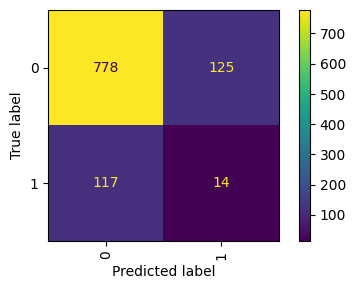


ROC AUC for test data :


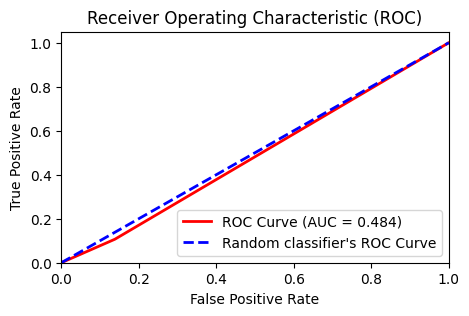

In [ ]:
dummy_clf.fit(X_test_tfidf,y_test)
evaluate_metrics(dummy_clf)

The results clearly show why we should not rely solely on the 'accuracy' metric when evaluating a model with an imbalanced dataset. Even with a dummy classifier that makes random predictions, we achieve almost 80% accuracy. However, the values of the F1 score and ROC AUC are both low, approximately 0.50.

### Logistic Regression

#### Hyperparameter Tuning

We are utilizing Grid Search cross-validation to fine-tune the hyperparameters of our machine learning models.  This technique enables us to systematically explore diverse combinations of hyperparameters, optimizing the model's performance.

In [ ]:
#Finding best hyper parameters using grid search cross-validation
hyp_params = [{"penalty":["elasticnet"],"C":[0.01,0.1,1.0],"solver":['saga'],"l1_ratio":[0.1,0.5,1.0]},
              {"penalty":["l2"],"C":[0.01,0.1,1.0],"solver":['lbfgs']},
              {"penalty":["l1","l2"],"C":[0.1,1.0],"solver":['liblinear']}
              ]

##following set of hyperparameter produces the best result
hyp_params = {'C': [1.0], 'penalty': ['l2'], 'solver': ['lbfgs']}

stratified_cv = StratifiedKFold(n_splits=5)
log_reg = LogisticRegression(random_state=42,max_iter=10000,class_weight="balanced")
model = GridSearchCV(log_reg,param_grid=hyp_params,cv=stratified_cv,n_jobs=3,verbose=1,scoring="f1_macro")

In [ ]:
model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42),
             n_jobs=3,
             param_grid={'C': [1.0], 'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='f1_macro', verbose=1)

In [ ]:
model.best_score_

0.934302885173212

In [ ]:
model.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

- Cross Validation scores :

In [ ]:
best_model = LogisticRegression(C=1.0,penalty='l2',solver='lbfgs',random_state=42,
                                max_iter=10000,class_weight="balanced")
cv_scores(best_model)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.934, std deviation = 0.005
roc_auc  : mean = 0.981, std deviation = 0.007
accuracy : mean = 0.972, std deviation = 0.002


#### Evaluation Metrics

In [ ]:
log_reg_final = best_model
log_reg_final.fit(X_train_tfidf,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

Train accuracy : 0.99
Test accuracy : 0.98

Train macro f1 score : 0.98
Test macro f1 score : 0.96

Train ROC AUC score : 1.00
Test ROC AUC score : 0.99


Classification report for test data:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.95      0.92      0.93       131

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034


Confusion matrix for test data:


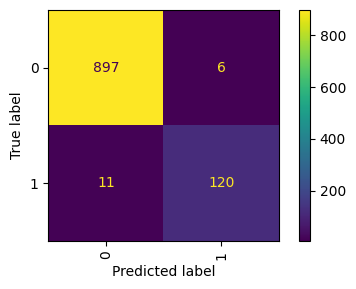


ROC AUC for test data :


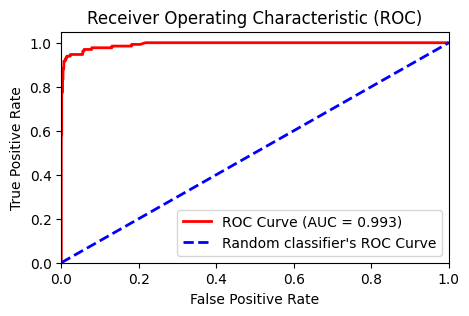

In [ ]:
evaluate_metrics(log_reg_final)

### Support Vector Classifier

#### Hyperparameter Tuning

In [ ]:
#Finding best hyper parameters using grid search cross-validation

hyp_params = [{
    'C': [0.01,0.1, 1],           # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type (linear, radial basis function, etc.)
    'class_weight': ['balanced'],  # Class weight to balance imbalanced datasets
}
              ]

##following set of hyperparameter produces the best result
hyp_params = {'C': [1], 'class_weight': ['balanced'], 'kernel': ['linear']}

stratified_cv = StratifiedKFold(n_splits=5)
svc = SVC(random_state=42,class_weight="balanced",probability=True)
model = GridSearchCV(svc,param_grid=hyp_params,cv=stratified_cv,n_jobs=3,verbose=1,scoring="f1_macro")

In [ ]:
model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=42),
             n_jobs=3,
             param_grid={'C': [1], 'class_weight': ['balanced'],
                         'kernel': ['linear']},
             scoring='f1_macro', verbose=1)

In [ ]:
model.best_score_

0.9351729066221413

In [ ]:
model.best_params_

{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}

- Cross validation scores :

In [ ]:
best_model = SVC(C=1,class_weight='balanced',kernel='linear',
                 random_state=42,probability=True)
cv_scores(best_model)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.935, std deviation = 0.013
roc_auc  : mean = 0.983, std deviation = 0.007
accuracy : mean = 0.973, std deviation = 0.005


#### Evaluation Metrics

In [ ]:
svc_final = best_model
svc_final.fit(X_train_tfidf,y_train)

SVC(C=1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)

Train accuracy : 1.00
Test accuracy : 0.98

Train macro f1 score : 0.99
Test macro f1 score : 0.96

Train ROC AUC score : 1.00
Test ROC AUC score : 0.99


Classification report for test data:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       903
           1       0.97      0.90      0.93       131

    accuracy                           0.98      1034
   macro avg       0.98      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034


Confusion matrix for test data:


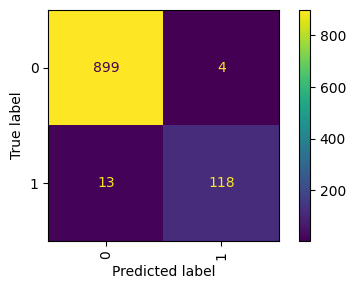


ROC AUC for test data :


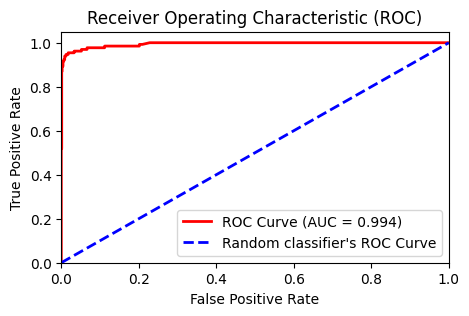

In [ ]:
evaluate_metrics(svc_final)

### Naive Bayes Classifier

#### Hyperparameter Tuning

In [ ]:
#Finding best hyper parameters using grid search cross-validation

##The best hyperparameters are decided from the following list
hyp_params = {'alpha': [0.01,0.1, 0.5, 1.0, 5.0],
             }

##following set of hyperparameter produces the best result
hyp_params = {'alpha': [0.1]}

model = GridSearchCV(MultinomialNB(),
                     param_grid=hyp_params,cv=5,n_jobs=3,verbose=1,scoring="f1_macro")


In [ ]:
model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=3,
             param_grid={'alpha': [0.1]}, scoring='f1_macro', verbose=1)

In [ ]:
model.best_score_

0.9312343470087032

In [ ]:
model.best_params_

{'alpha': 0.1}

- Cross Validation scores :

In [ ]:
best_model = MultinomialNB(alpha=0.01)
cv_scores(best_model)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.924, std deviation = 0.019
roc_auc  : mean = 0.983, std deviation = 0.006
accuracy : mean = 0.965, std deviation = 0.01


#### Evaluation Metrics

In [ ]:
nb_final = best_model
nb_final.fit(X_train_tfidf,y_train)

MultinomialNB(alpha=0.01)

Train accuracy : 1.00
Test accuracy : 0.98

Train macro f1 score : 1.00
Test macro f1 score : 0.95

Train ROC AUC score : 1.00
Test ROC AUC score : 0.98


Classification report for test data:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.97      0.86      0.91       131

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034


Confusion matrix for test data:


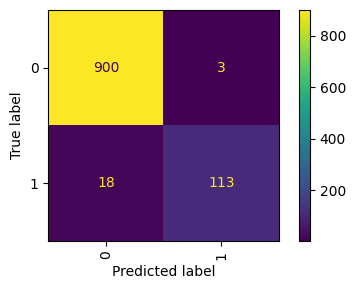


ROC AUC for test data :


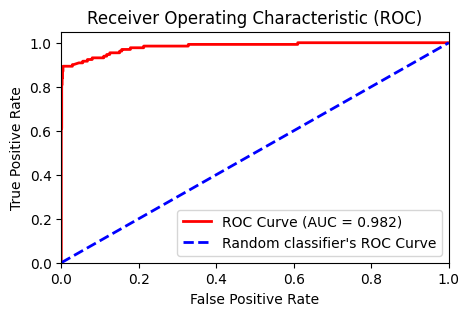

In [ ]:
evaluate_metrics(nb_final)

### Decision Tree Classifier

#### Hyperparameter Tuning

In [ ]:
hyp_params = {
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 10, 30, 50],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 50] }

##following set of hyperparameter produces the best result
hyp_params = {'max_depth': [None], 'max_features': ['sqrt'], 'max_leaf_nodes': [None],
              'min_samples_leaf':[1], 'min_samples_split': [2]}

stratified_cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight='balanced'),
                     param_grid=hyp_params,cv=stratified_cv,n_jobs=3,verbose=1,scoring="f1_macro")


In [ ]:
model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=3,
             param_grid={'max_depth': [None], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [2]},
             scoring='f1_macro', verbose=1)

In [ ]:
model.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
model.best_score_

0.8555794795418225

- Cross validation scores :

In [ ]:
best_model = DecisionTreeClassifier(max_depth=None,max_features='sqrt',max_leaf_nodes=None,
                                             min_samples_leaf=1,min_samples_split=2,random_state=42,
                                             class_weight='balanced')
cv_scores(best_model)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.856, std deviation = 0.034
roc_auc  : mean = 0.838, std deviation = 0.031
accuracy : mean = 0.939, std deviation = 0.015


#### Evaluation Metrics

In [ ]:
decision_tree_final = best_model

decision_tree_final.fit(X_train_tfidf,y_train)

DecisionTreeClassifier(class_weight='balanced', max_features='sqrt',
                       random_state=42)

Train accuracy : 1.00
Test accuracy : 0.93

Train macro f1 score : 1.00
Test macro f1 score : 0.84

Train ROC AUC score : 1.00
Test ROC AUC score : 0.85


Classification report for test data:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       903
           1       0.71      0.74      0.73       131

    accuracy                           0.93      1034
   macro avg       0.84      0.85      0.84      1034
weighted avg       0.93      0.93      0.93      1034


Confusion matrix for test data:


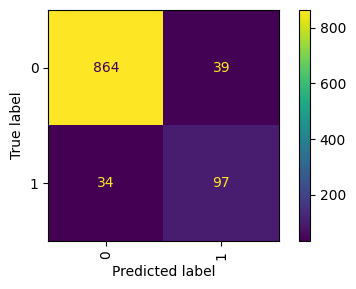


ROC AUC for test data :


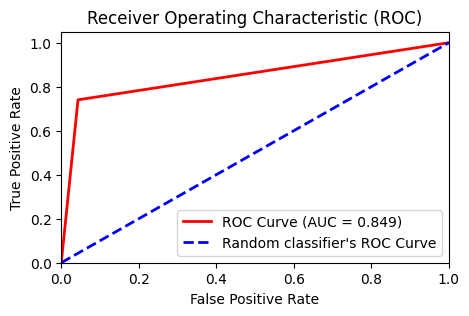

In [ ]:
evaluate_metrics(decision_tree_final)

### Random Forest Classifier

#### Hyperparameter Tuning

In [ ]:
hyp_params = {"n_estimators":[100,200],
                  "max_depth":[5,10,20,None],
                  'max_features': ['sqrt', 'log2'],
                  "min_samples_split":[2,5,10,50],
                  'min_samples_leaf': [1, 2],
              }

##following set of hyperparameter produces the best result
hyp_params = {'max_depth':[None],'max_features': ['log2'],'min_samples_leaf':[1],
              'min_samples_split':[50],'n_estimators':[200]}

stratified_cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(RandomForestClassifier(random_state=42,class_weight='balanced'),
                     param_grid=hyp_params,cv=stratified_cv,n_jobs=3,verbose=1,scoring="f1_macro")

In [ ]:
model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=3,
             param_grid={'max_depth': [None], 'max_features': ['log2'],
                         'min_samples_leaf': [1], 'min_samples_split': [50],
                         'n_estimators': [200]},
             scoring='f1_macro', verbose=1)

In [ ]:
model.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'n_estimators': 200}

In [ ]:
model.best_score_

0.9452306497499713

- Cross validation scores :

In [ ]:
best_model = RandomForestClassifier(max_depth=None,max_features='log2',min_samples_leaf=1,
                                    min_samples_split=50,n_estimators=200, random_state=42,
                                    class_weight='balanced')
cv_scores(best_model)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.945, std deviation = 0.011
roc_auc  : mean = 0.98, std deviation = 0.007
accuracy : mean = 0.978, std deviation = 0.004


#### Evaluation Metrics

In [ ]:
random_forest_final = best_model
random_forest_final.fit(X_train_tfidf,y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_split=50, n_estimators=200, random_state=42)

Train accuracy : 1.00
Test accuracy : 0.98

Train macro f1 score : 1.00
Test macro f1 score : 0.96

Train ROC AUC score : 1.00
Test ROC AUC score : 0.99


Classification report for test data:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.99      0.86      0.92       131

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034


Confusion matrix for test data:


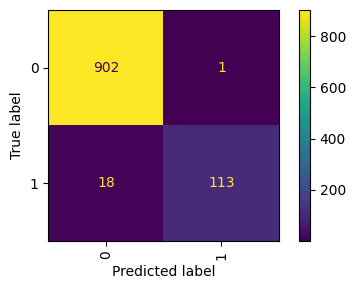


ROC AUC for test data :


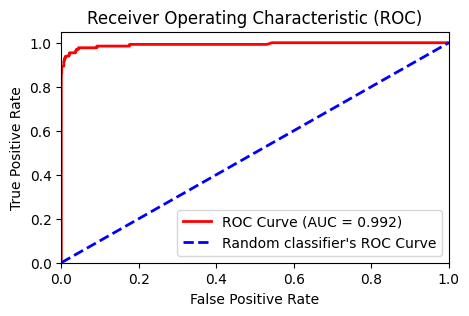

In [ ]:
evaluate_metrics(random_forest_final)

### XGBoost classifier

#### Hyperparameter Tuning

In [ ]:
#adjusting class weights for imbalanced labels
# Calculate the class weight ratio (negative class count / positive class count)
class_weight_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

hyp_params = {'learning_rate': [0.1,0.3],
    'max_depth': [2,3,4],
    'n_estimators': [100, 200],
    'min_child_weight': [1,2,3],
    'subsample': [0.8,  1.0]
              }

##default
#hyp_params = {'learning_rate': [0.1], 'max_depth': [3], 'min_child_weight': [1], 'n_estimators': [100], 'subsample': [1]}
##following set of hyperparameter produces the best result
hyp_params = {'learning_rate': [0.3], 'max_depth': [4], 'min_child_weight': [1], 'n_estimators': [200],
              'subsample': [1]}

stratified_cv = StratifiedKFold(n_splits=5)


model = GridSearchCV(XGBClassifier(random_state=42,scale_pos_weight= class_weight_ratio),
                     param_grid=hyp_params,cv=stratified_cv,n_jobs=-1,verbose=1,scoring="f1_macro")

model.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.3], 'max_depth': [4],
                         'min_child_weight': [1], 'n_estimators': [200],
                         'subsample': [1]},
             scoring='f1_macro', verbose=1)

In [ ]:
model.best_params_

{'learning_rate': 0.3,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 1}

In [ ]:
model.best_score_

0.9207259290703483

- Cross validation scores :

In [ ]:
best_model = XGBClassifier(learning_rate=0.3,max_depth= 4,min_child_weight= 1,
                           n_estimators= 200,subsample=1.0,random_state=42,
                           scale_pos_weight= class_weight_ratio)
cv_scores(best_model)

Cross validation scores of the model with best hyperparameters:

macro f1 : mean = 0.921, std deviation = 0.012
roc_auc  : mean = 0.964, std deviation = 0.019
accuracy : mean = 0.966, std deviation = 0.005


#### Evaluation Metrics

In [ ]:
xgb_final = best_model
xgb_final.fit(X_train_tfidf,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Train accuracy : 1.00
Test accuracy : 0.98

Train macro f1 score : 1.00
Test macro f1 score : 0.95

Train ROC AUC score : 1.00
Test ROC AUC score : 0.98


Classification report for test data:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       903
           1       0.95      0.87      0.91       131

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034


Confusion matrix for test data:


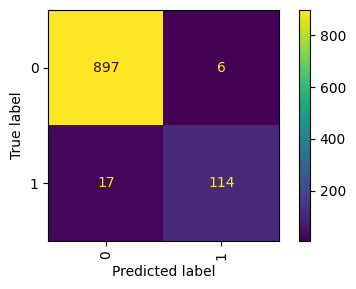


ROC AUC for test data :


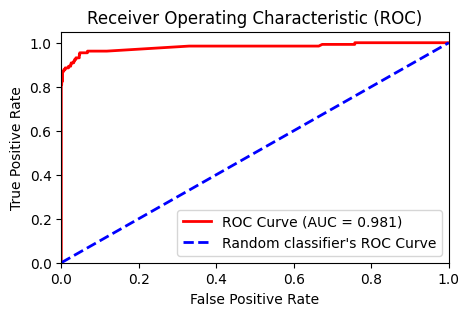

In [ ]:
evaluate_metrics(xgb_final)

### Comparing Performance of Different Models

In [ ]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
train_auc = []
test_auc = []
classifiers = [log_reg_final,svc_final,nb_final,decision_tree_final,random_forest_final,xgb_final]
for  model in classifiers:
    y_train_pred = model.predict(X_train_tfidf)
    y_train_scores = model.predict_proba(X_train_tfidf)[:, 1]

    y_test_pred = model.predict(X_test_tfidf)
    y_test_scores = model.predict_proba(X_test_tfidf)[:, 1]

    train_acc.append(round(accuracy_score(y_train,y_train_pred),3))
    test_acc.append(round(accuracy_score(y_test,y_test_pred),3))

    train_f1.append(round(f1_score(y_train,y_train_pred,average='macro'),3))
    test_f1.append(round(f1_score(y_test,y_test_pred,average='macro'),3))

    train_auc.append(round(roc_auc_score(y_train, y_train_scores),3))
    test_auc.append(round(roc_auc_score(y_test, y_test_scores),3))

metrics = {"classifier":["Logistic Regression","Support Vector Machine","Naive Bayes","Decision tree","Random Forest","XGBoost"],
 "Train_accuracy":train_acc, "Test_accuracy":test_acc, "Train_f1_macro":train_f1, "Test_f1_macro":test_f1,
 "Train_ROC_AUC":train_auc,"Test_ROC_AUC":test_auc}



multi_columns = [("Classifier model",""),("Accuracy","Train"),("Accuracy","Test"),
                 ("f1_macro","Train"),("f1_macro","Test"),("ROC_AUC","Train"),("ROC_AUC","Test")
]

metrics_df = pd.DataFrame(metrics)
metrics_df.columns = pd.MultiIndex.from_tuples(multi_columns)
#metrics_df = metrics_df.style.set_properties(**{'text-align': 'left'}, subset=pd.IndexSlice[:, :])
metrics_df


Classifier model Accuracy        f1_macro        ROC_AUC       
                             Train   Test    Train   Test   Train   Test
0     Logistic Regression    0.992  0.984    0.981  0.962   0.999  0.993
1  Support Vector Machine    0.997  0.984    0.993  0.962   0.999  0.994
2             Naive Bayes    0.998  0.980    0.995  0.952   1.000  0.982
3           Decision tree    1.000  0.929    1.000  0.843   1.000  0.849
4           Random Forest    0.998  0.982    0.996  0.956   1.000  0.992
5                 XGBoost    0.998  0.978    0.995  0.948   0.999  0.981

Most of the models, especially Logistic Regression and the Support Vector Classifier, exhibited exceptional performance on both the training and test datasets, suggesting their strong generalization capabilities. The top-performing models achieved an F1 score surpassing 0.96 on the test data, along with ROC AUC scores exceeding 0.99. This highlights their robustness in effectively distinguishing between legitimate and spam messages.

More rigorous hyperparameter tuning and exploration of additional algorithms may produce an even more improved model.

## Conclusions <a id="conclusions"></a>

- In this spam SMS detection project, we evaluated the performance of six distinct machine learning classifier models: Logistic Regression, Support Vector Machine, Naive Bayes, Decision Tree, Random Forest, and XGBoost. All these models performed significantly better than the baseline model, which was a dummy classifier. This highlights the valuable role that machine learning can play in accurately predicting spam messages based on textual information.

- Most of the ML models, especially Logistic Regression and Support Vector classifier, demonstrated outstanding performance with exceptional values for accuracy, f1-score, and ROC AUC. They generalized very well to unseen data, maintaining a nice balance between precision and recall. The well-shaped ROC curve further indicates their effectiveness in discriminating between spam and ham.

- This project also demonstrates the importance of choosing appropriate evaluation metrics for classification tasks. When working with imbalanced datasets, accuracy alone is not a reliable indicator of performance. Instead, we should consider various other metrics such as f1-score, precision, recall, and ROC AUC score.

- As a potential future extension, the implementation of deep learning may produce a further improved model for spam SMS detection.